# COMPUTER VISION EXERCISE 5.1

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Estimated Camera Matrices from Ex 3
P1 = np.array([
    [0.10413351, -0.01099711, -0.1597092, 0.08281875],
    [-0.08005905, 0.15966437, -0.06275416, 0.85534144],
    [0.01131988, 0.00739613, 0.00713581, 0.43472556]
])

P2 = np.array([
    [0.13122934, -0.00362166, -0.13645265, -0.00224321],
    [-0.07094015, 0.16048414, -0.07138061, 0.85880576],
    [0.00926429, 0.00809274, 0.00941618, 0.43643008]
]  )
import json

# Load points x1 and x2 from a JSON file
with open('points.json', 'r') as f:
    data = json.load(f)
    x1 = np.array(data['x1'][:])
    x2 = np.array(data['x2'][:])


    

In [5]:
import numpy as np

def triangulate_points(P1, P2, pts1, pts2):
    """
    Triangulate 3D points from corresponding 2D points in two images using DLT.
    
    :param P1: 3x4 Camera Projection Matrix 1
    :param P2: 3x4 Camera Projection Matrix 2
    :param pts1: Nx2 array of 2D points in image 1
    :param pts2: Nx2 array of 2D points in image 2
    :return: Nx3 array of triangulated 3D points
    """
    num_points = pts1.shape[0]
    X_3D = np.zeros((num_points, 3))

    for i in range(num_points):
        x1, y1 = pts1[i]
        x2, y2 = pts2[i]

        # Construct the A matrix
        A = np.array([
            x1 * P1[2, :] - P1[0, :],
            y1 * P1[2, :] - P1[1, :],
            x2 * P2[2, :] - P2[0, :],
            y2 * P2[2, :] - P2[1, :]
        ])

        # Solve using SVD
        _, _, Vt = np.linalg.svd(A)
        X = Vt[-1, :]  # Last row of Vt (smallest singular value)

        # Convert homogeneous to Cartesian coordinates
        X_3D[i] = X[:3] / X[3]

    return X_3D



X_3D = triangulate_points(P1, P2, x1, x2)
#print("Triangulated 3D Points:\n", X_3D)


In [6]:
def project_points(P, X_3D, img_shape):
    """
    Project 3D points back into the image using the camera matrix P.
    Properly normalizes homogeneous coordinates and removes out-of-bounds points.

    :param P: 3x4 camera projection matrix
    :param X_3D: Nx3 array of 3D points
    :param img_shape: (height, width) of the image
    :return: Nx2 array of valid projected 2D points
    """
    # Convert 3D points to homogeneous coordinates
    X_hom = np.hstack((X_3D, np.ones((X_3D.shape[0], 1))))
    
    # Project into image plane (homogeneous coordinates)
    x_proj_hom = (P @ X_hom.T).T
    
    # Extract x, y, and homogeneous coordinate (w)
    x_proj = x_proj_hom[:, :2]
    w = x_proj_hom[:, 2].reshape(-1, 1)  # Keep w as a column vector

    # Ensure w is not too small to avoid division issues
    w[np.abs(w) < 1e-8] = np.sign(w[np.abs(w) < 1e-8]) * 1e-8  # Avoid near-zero division

    # Normalize x, y coordinates by w
    x_proj /= w

    # Get image dimensions
    h, w = img_shape

    # Filter out points that are out of bounds
    valid_mask = (x_proj[:, 0] >= 0) & (x_proj[:, 0] < w) & (x_proj[:, 1] >= 0) & (x_proj[:, 1] < h)
    
    # Keep only valid points
    x_proj = x_proj[valid_mask]

    return x_proj




Number of keypoints in image1: 6411
Number of keypoints in image2: 7334
Number of good matches after ratio test: 1373


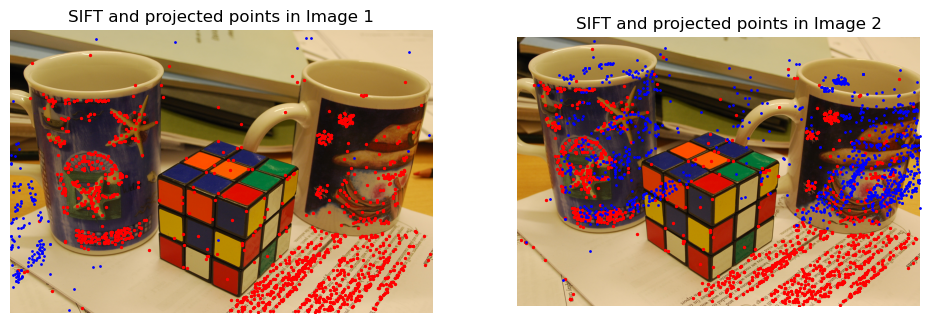

Out of bounds points in Image 1: 0
Out of bounds points in Image 2: 0


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the images
im1 = cv2.imread('cube1.jpg')
im2 = cv2.imread('cube2.jpg')

if im1 is None or im2 is None:
    print("Error: Could not load images. Check file paths.")
    exit()

# Convert to grayscale
gray1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

# Create the SIFT detector and detect keypoints + descriptors
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

print(f"Number of keypoints in image1: {len(kp1)}")
print(f"Number of keypoints in image2: {len(kp2)}")

# Match the descriptors
bf = cv2.BFMatcher(cv2.NORM_L2)
matches_knn = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
ratio_thresh = 0.7
good_matches = [m for m, n in matches_knn if m.distance < ratio_thresh * n.distance]

print(f"Number of good matches after ratio test: {len(good_matches)}")

# Extract matched keypoints locations
SIFT_points1 = np.array([kp1[m.queryIdx].pt for m in good_matches])
SIFT_points2 = np.array([kp2[m.trainIdx].pt for m in good_matches])

# Get image dimensions
img_shape = im1.shape[:2]  # (height, width)

# Project back into images using the improved function
proj1 = project_points(P1, X_3D, img_shape)
proj2 = project_points(P2, X_3D, img_shape)

# Plot keypoints without lines
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot keypoints for first image
ax[0].imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
ax[0].scatter(SIFT_points1[:, 0], SIFT_points1[:, 1], c='r', s=2)
ax[0].scatter(proj1[:, 0], proj1[:, 1], c='b', s=1)
ax[0].set_title("SIFT and projected points in Image 1")
ax[0].axis("off")

# Plot keypoints for second image
ax[1].imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
ax[1].scatter(SIFT_points2[:, 0], SIFT_points2[:, 1], c='r', s=2)
ax[1].scatter(proj2[:, 0], proj2[:, 1], c='b', s=1)
ax[1].set_title("SIFT and projected points in Image 2")
ax[1].axis("off")

plt.show()
h, w, _ = im1.shape  # Image dimensions
print("Out of bounds points in Image 1:", np.sum((proj1[:, 0] < 0) | (proj1[:, 0] > w) | (proj1[:, 1] < 0) | (proj1[:, 1] > h)))
print("Out of bounds points in Image 2:", np.sum((proj2[:, 0] < 0) | (proj2[:, 0] > w) | (proj2[:, 1] < 0) | (proj2[:, 1] > h)))